In [80]:
import pandas as pd 
import sqlalchemy as db 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt 
import sqlite3 as sql

# define a function to create a time series with frequency. 
def create_time_series(df, f = 'D'):
    df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d')
    return df.asfreq(f).bfill()

# connect to the database
engine = db.create_engine('sqlite:////Users/jerald/Documents/Dir/Python/StockOptions/DataPipeline/test.db')
connection = engine.connect()
stocks = pd.read_sql_table('stocks', connection)

import yfinance as yf
# get the data from yahoo finance
tickers = yf.Tickers(' '.join(stocks.stocks))
stock_prices = tickers.download(start = '2000-01-01')

[*********************100%***********************]  155 of 155 completed


In [81]:
stocks_names = stocks['stocks'].to_list()

Finding the expected return on all of the stocks that we follow. 

In [82]:
from glob import glob 
from datetime import datetime 
today = datetime.today().strftime('%Y-%m-%d')


def display_side_by_side(dfs:list, captions:list):
    from IPython.core.display import display, HTML
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

# get ohlcv for a prticular symbol 
def add_stock_price(stock, sp):
    sp = sp.swaplevel(axis = 1).copy()
    out = sp.xs(key = stock.upper(), axis = 1).copy()
    out.columns.names = ['']
    out.columns = out.columns.get_level_values(0)
    out.index = pd.DatetimeIndex(out.index)
    out['week'] = out.index.isocalendar().week
    out['month'] = out.index.month
    out['day'] = out.index.dayofweek
    return out

lod = {x: add_stock_price(x, sp = stock_prices) for x in stocks_names}

In [83]:
# Reduce weekly, monthly, quarter, yearly etc.
def reduce_df(stock_prices, period = 'W'):
    """Availible options for period: W, M, Q, Y, aggregate 2 weeks, months, etc. with '2W'.. etc"""
    df = stock_prices.copy()
    df = df.resample(period).agg({
        'Open': lambda s: s[0],
        'High': lambda df: df.max(),
        'Low': lambda df: df.min(),
        'Close': lambda df: df[-1],
        'Volume': lambda df: df.sum()})
    return df

# Daily Return
lor = {x:{'Daily':lod[x]['Close'].pct_change(),
        'Weekly':reduce_df(lod[x], period='W')['Close'].pct_change(),
        'Monthly':reduce_df(lod[x], period='M')['Close'].pct_change(),
        'Quarterly': reduce_df(lod[x], period='Q')['Close'].pct_change(),
        'Yearly':reduce_df(lod[x], period='Y')['Close'].pct_change()
        } for x in stocks_names}

In [84]:
expected_returns = {}
for x in stocks_names: 
    period_keys = list(lor[x].keys())
    expected_returns[x] = {j:{'Mean':np.mean(lor[x][j]), 'Std_dev': np.std(lor[x][j])}  for j in period_keys}

In [85]:
lodf = []
for x in stocks_names:
    tdf = pd.DataFrame.from_dict(expected_returns[x]) 
    tdf['Stock'] = x
    lodf.append(tdf)

The expected return is the anticipated profit/loss on an investment with historical known rates of return. To calcualte the expected return, one must first devise multiple potential outcomes, and determine the chances of those outcomes occuring.

Example suppose that an investment has a 50% chance of _gaining_ 20% and a 50% chance of _Losing_ 10%. The expected return then is:

$$E[r] = p_{gain} * x_{return\%} + (1- p_{gain}) * x_{loss\%} \\ E[r] = 50\% * 20\% + 50\% * -10\%  \\ E[r] = 5\%$$

# $$\Epsilon[r] = \sum_{i = 1}^{n} r_i p_i $$ 

$$\\  E[r] =  \text{Expected Return} \\ r_i = \text{Return in Scenario } i \\ p_i = \text{Probability for the return in Scenario } i \\ n = \text{Number of Scenarios }$$


# $$\bar{r}_a = r_f + \beta_a(r_m - r_f)$$
$$ \\ \text{Where} r_a = \text{expected return} \\ r_f = \text{risk free rate} \\ \beta  = \text{investment beta} \\ r_m = \text{expected market return }$$

In [98]:
from IPython.display import display
N_OUT = 5

t = pd.concat(lodf) 
MeanDF , Std_DF= t.loc['Mean'].reset_index(drop = True).set_index('Stock') , t.loc['Std_dev'].reset_index(drop = True).set_index('Stock')
AVG_RETURN = [MeanDF[x].sort_values(ascending = False).tail(10) for x in MeanDF.columns.to_list()]
STD_RETURN = [Std_DF[x].sort_values(ascending = False).tail() for x in Std_DF.columns.to_list()]

print('--- Return Leaders ----')
display_side_by_side([pd.DataFrame(x) for x in AVG_RETURN], MeanDF.columns.to_list())

#print('---  Standard Deviation Leaders ----')
#display_side_by_side([pd.DataFrame(x) for x in STD_RETURN], Std_DF.columns.to_list())


--- Return Leaders ----


,Daily
Stock,
tmv,-0.000477
lc,-0.000485
vxx,-0.000647
ung,-0.000918
coin,-0.001466
afrm,-0.001495
bito,-0.001600
hood,-0.001720
dcfc,-0.002601


In [103]:
MeanDF.sort_values("Weekly", ascending = False).head(10)

,Daily,Weekly,Monthly,Quarterly,Yearly
Stock,,,,,
dwac,0.009429,0.092090,0.270717,0.542298,-0.420171
spi,0.011228,0.036828,0.101005,0.336870,0.272605
bkkt,0.001865,0.013892,0.041954,-0.123317,-0.236399
reta,0.003028,0.013175,0.063491,0.173788,0.645202
qs,0.002432,0.012521,0.083039,0.230943,-0.374859
mara,0.003641,0.012342,0.042933,0.207286,1.098164
enph,0.002540,0.012222,0.053602,0.151962,1.215291
mdb,0.002282,0.010980,0.044863,0.144083,0.678437
tsla,0.002146,0.010510,0.046762,0.154959,0.983245


In [88]:
import plotly.graph_objs as go
import plotly.express as px 

def ohlcv_plot(data, w = 500, h = 500 ):
    n1 = 6
    n2 = 28
    n3 = 96
    n4 = 200
    #n4 = 127
    n5 = 272
    n6 = 496
    #plotting data with plotly
    #first you must declare a figure this is the shell it seems 
    fig = go.Figure()
    data['Date'] = pd.DatetimeIndex(data.index)
    #Start the candlestick chart
    fig.add_trace(go.Candlestick(x = data['Date'],
                                open = data['Open'],
                                high = data['High'],
                                low = data['Low'],
                                close = data['Close'],
                                ))

    #add lines for the close
    fig.add_trace(go.Scatter(x=list(data['Date']), y=list(data.Close.rolling(n1).mean()),name=f'{n1} MA'))
    fig.add_trace(go.Scatter(x=list(data['Date']), y=list(data.Close.rolling(n2).mean()),name=f'{n2} MA'))
    fig.add_trace(go.Scatter(x=list(data['Date']), y=list(data.Close.rolling(n3).mean()),name=f'{n3} MA'))
    fig.add_trace(go.Scatter(x=list(data['Date']), y=list(data.Close.rolling(n4).mean()),name=f'{n4} MA'))
    fig.add_trace(go.Scatter(x=list(data['Date']), y=list(data.Close.rolling(n5).mean()),name=f'{n5} MA'))
    fig.add_trace(go.Scatter(x=list(data['Date']), y=list(data.Close.rolling(n6).mean()),name=f'{n6} MA'))
    # Add titles 
    fig.update_layout(
        title = f'Stock Price',
        yaxis_title = 'Stock Price (USD per Share)')

    # X axis 
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=28, label="28d", step="day", stepmode="backward"),
                dict(count=496, label="496d", step="day", stepmode="backward"),
                dict(count=5, label="5yr", step="year", stepmode="backward"),
                dict(count=10, label="10yr", step="year", stepmode="todate"),
                dict(step="all")
            ])
        )
    )
    fig.update_xaxes(scaleanchor = "y",scaleratio = 1)
    #fig.update_yaxes(range=(data.Close.min(),data.Close.max()),constrain='domain')
    #fig.update_layout(width = w,height = h)
    fig.update_yaxes(fixedrange=False)
    # Show the plot 
    fig.show()

In [89]:
ohlcv_plot(lod['spy'], 800, 500)

In [90]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

def ts_analysis(stock, n_periods = 252):
    assert type(n_periods) == int
    "Return time series decomposition for dataframe. Set Show_plots = False to return data"
    df = lod[stock].dropna().sort_index().copy()
    assert n_periods < len(df), "Number of Periods given is greater than the data given "
    # Additive Decomposition
    additive = seasonal_decompose(df['Close'], model='additive', extrapolate_trend='freq',period=n_periods)
    # Multiplicative Decomposition 
    multiplicative = seasonal_decompose(df['Close'], model='multiplicative', extrapolate_trend='freq', period=n_periods)
    fig, axes = plt.subplots(4,2, figsize = (15,8))
    axes[0,0].plot(additive.observed, color = 'Black')
    axes[1,0].plot(additive.trend, color = 'orange')
    axes[2,0].plot(additive.seasonal, color = 'green')
    axes[3,0].plot(additive.resid, color = 'red')
    axes[0,1].plot(multiplicative.observed, color = 'Black')
    axes[1,1].plot(multiplicative.trend, color = 'orange')
    axes[2,1].plot(multiplicative.seasonal, color = 'green')
    axes[3,1].plot(multiplicative.resid, color = 'red')

    axes[0,0].set_title("Additive")
    axes[1,0].set_title("Trend")
    axes[2,0].set_title("Seasonality")
    axes[3,0].set_title("Residuals")
    axes[0,1].set_title("Multiplicative")
    axes[1,1].set_title("Trend")
    axes[2,1].set_title("Seasonality")
    axes[3,1].set_title("Residuals")

    fig.suptitle('Time Series Decomposition')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
    return {stock: {'additive': additive, 'multiplicative': multiplicative}}



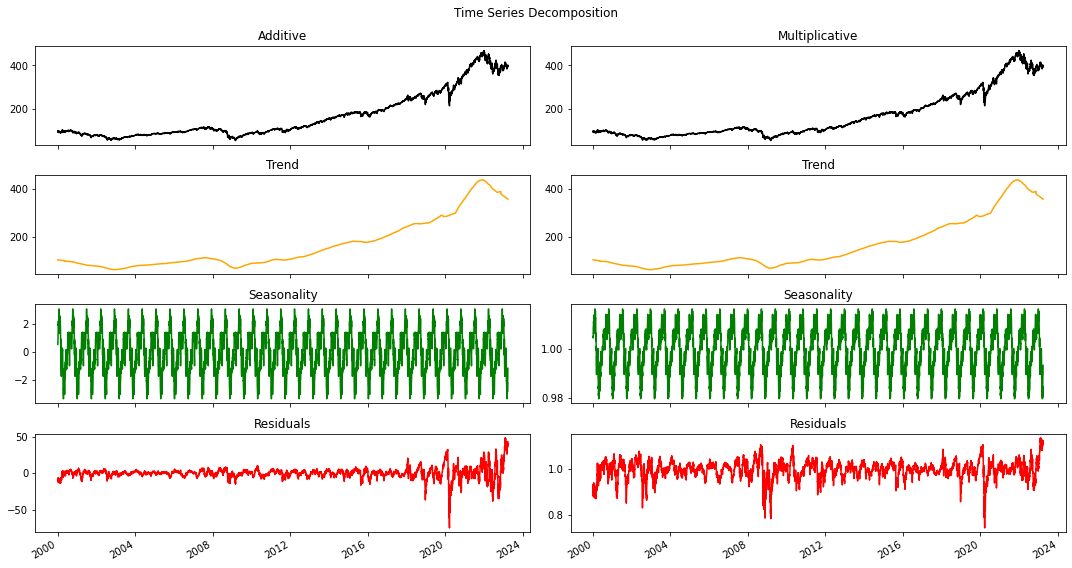

In [91]:
#Perfect Numbers: 6, 28, 496, 8128 
d = ts_analysis('spy', n_periods= 180)

In [92]:
def recent_performance(symbol, show_numbers = False):
    k = list(lor[symbol].keys())
    one_day_change = lor[symbol][k[0]].iloc[-1]
    one_week_change = lor[symbol][k[1]].iloc[-1]
    one_month_change = lor[symbol][k[2]].iloc[-1]
    one_quarter_change = lor[symbol][k[3]].iloc[-1]
    one_year_change = lor[symbol][k[4]].iloc[-1]
    if show_numbers == True:
        print(f'${symbol.upper()} Change:\nOne Day change: {one_day_change:.2%}\nOne Week: {one_week_change:.2%}\nOne Month: {one_month_change:.2%}\nOne quarter Change: {one_quarter_change:.4%}\nOne Year Change: {one_year_change:.4f}%')
    return {symbol:  {'Day':one_day_change,'Week':one_week_change,'Month':one_month_change,'Quarter':one_quarter_change,'Year':one_year_change}}

print(stocks)

    stocks  is_etf  is_equity                                        name
0      gdx     1.0        0.0                      VanEck Gold Miners ETF
1      gme     0.0        1.0                              GameStop Corp.
2     amzn     0.0        1.0                            Amazon.com, Inc.
3      spy     1.0        0.0                      SPDR S&P 500 ETF Trust
4      xlf     1.0        0.0           Financial Select Sector SPDR Fund
..     ...     ...        ...                                         ...
151    cag     0.0        1.0                        Conagra Brands, Inc.
152   reta     0.0        1.0                 Reata Pharmaceuticals, Inc.
153   uvxy     1.0        0.0  ProShares Ultra VIX Short-Term Futures ETF
154    bil     1.0        0.0         SPDR Bloomberg 1-3 Month T-Bill ETF
155    shy     1.0        0.0          iShares 1-3 Year Treasury Bond ETF

[156 rows x 4 columns]


In [93]:
performance_list = []
# Append each performance to a list 
for i in stocks.stocks:
    performance_list.append(recent_performance(i))

# Create dataframe and populate
perf_df = pd.DataFrame(columns=['stock', 'daily', 'weekly', 'monthly', 'quarterly', 'yearly'])
for i in range(len(performance_list)):
    st = list(performance_list[i].keys())[0]
    perf_df.loc[i,'stock'] = st
    perf_df.loc[i,'daily'] = performance_list[i][st]['Day']
    perf_df.loc[i,'weekly'] = performance_list[i][st]['Week']
    perf_df.loc[i,'monthly'] = performance_list[i][st]['Month']
    perf_df.loc[i,'quarterly'] = performance_list[i][st]['Quarter']
    perf_df.loc[i,'yearly'] = performance_list[i][st]['Year']

perf_df.set_index('stock', inplace = True)

In [94]:
perf_df.sort_values('weekly', ascending=False).head(20)

,daily,weekly,monthly,quarterly,yearly
stock,,,,,
ardx,0.104289,0.165025,0.61809,0.635123,0.635123
lulu,0.134838,0.159675,0.175614,0.13459,0.13459
baba,0.015752,0.150173,0.138512,0.134635,0.134635
sq,0.050907,0.104248,-0.126733,0.066292,0.066292
amc,-0.045631,0.099553,-0.311625,0.207617,0.207617
mos,0.047537,0.078674,-0.132543,0.051744,0.051744
ccj,0.021533,0.075499,-0.054316,0.140494,0.140494
li,0.012525,0.071856,0.061415,0.228431,0.228431
tmv,0.007804,0.07157,-0.089134,-0.156789,-0.156789


In [95]:
o=recent_performance('tsla', show_numbers=True)

$TSLA Change:
One Day change: 2.21%
One Week: 1.56%
One Month: -5.99%
One quarter Change: 56.9898%
One Year Change: 0.5699%


In [97]:
for i in stocks.stocks:
    mi = MomentumIndicator(i)
    if mi.is_bearish():
        print(f'{i} is bearish')

aal is bearish
uber is bearish
uup is bearish
ntr is bearish
sq is bearish
fcel is bearish
vale is bearish
mo is bearish
wfc is bearish
mrk is bearish
mos is bearish
tgt is bearish
rblx is bearish
sono is bearish
hsbc is bearish
gsl is bearish
ung is bearish
cmre is bearish
aa is bearish
run is bearish
roku is bearish
spwr is bearish
abnb is bearish
dcfc is bearish
hood is bearish
